In [23]:
import pandas as pd
from editdistance import distance
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from io import StringIO
from html.parser import HTMLParser

In [608]:
df_original = pd.read_csv("data/raw/context_100/ocr_corrections.tsv", sep="\t", encoding="utf8")

In [609]:
df = df_original.rename(columns={"OldTextValue": "oldtext", "NewTextValue": "newtext"})

### Preprocessing

In [611]:
document_id_pattern = r"(?P<title>[A-Za-z]+)(?P<year>[12]\d{3})(?P<month>[01]\d)(?P<day>[0123]\d)?(-(?P<issue>\d{1,2}))?"

In [612]:
class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()


def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()


def strip_nlib_watermark(s):
    watermark = "@@@@@_NationalLibraryofEstonia_DigitalCollectionsData_SeeUsageRights_in_data.digar.ee_@@@@@"
    if watermark in s:
        return s.replace(watermark, "")
    elif "@@" in s:
        if len(s) - s.index("@@") < 90:
            return s[:s.index("@@")]
    else:
        return s


def clean_text(s):
    return strip_nlib_watermark(strip_tags(s))

In [613]:
def extract_name_and_year(documentID: str, pattern=document_id_pattern):
    if type(documentID) == str:
        match = re.match(pattern, documentID)
        if match:
            title, year = match.groups()[:2]
            return title, int(year)

In [614]:
def count_symbol_types(s: str):
    l = len(s)
    numbers = sum(c.isdigit() for c in s)
    letters = sum(c.isalpha() for c in s)
    spaces  = sum(c.isspace() for c in s)
    others  = len(s) - numbers - letters - spaces

    return (letters/l, numbers/l, spaces/l, others/l)

In [615]:
# create unique IDs across blocks
df["blockIDunique"] = df["pageOID"] + df["blockID"]

In [616]:
# extract dates and titles
df[["title", "year"]] = df.DocumentID.apply(extract_name_and_year).to_list()

In [617]:
# clean HTML tags and @@@@ watermarks from text
df["oldtext"] = df["oldtext"].apply(clean_text)
df["newtext"] = df["newtext"].apply(clean_text)
df["context_old"] = df["context_old"].apply(clean_text)
df["context_new"] = df["context_new"].apply(clean_text)

In [618]:
# calculate text lengths and increase in length, absolute + relative
df["len_old"] = df["oldtext"].str.len()
df["len_new"] = df["newtext"].str.len()
df["len_increase"] = df["len_new"] - df["len_old"]
df["len_increase_relative"] = df["len_increase"] / df["len_old"]

In [619]:
# remove all rows where the old or new text turned out to bo 0 after cleaning
df = df.loc[(df["context_old"].str.len() > 0) & (df["context_new"].str.len() > 0) & (df["oldtext"].str.len() > 0) & (df["newtext"].str.len() > 0)].copy()

In [620]:
# count share of letter, number, special characters and whitespaces
df[["old_string", "old_number", "old_space", "old_other"]] = df["context_old"].apply(count_symbol_types).to_list()
df[["new_string", "new_number", "new_space", "new_other"]] = df["context_new"].apply(count_symbol_types).to_list()

In [621]:
# calculate edit distance, absolute + relative
df["edit_distance"] = df.apply(lambda row: distance(row.oldtext, row.newtext), axis=1)
df["edit_distance_relative"] = df["edit_distance"] / df["len_old"]

In [622]:
# add OCR accuracy on page-level
meta = pd.read_csv("data/raw/context_100/corrected_pages_meta.tsv", sep="\t", encoding="utf8")
meta.replace({"PageOCRAccuracy": "%"}, None, inplace=True)
meta["page_ocr_acc"] = meta["PageOCRAccuracy"].apply(lambda x: float(x.strip("%"))/100 if type(x) == str else None)
df["ocr_acc"] = df["pageOID"].map(meta.set_index("PageID")["page_ocr_acc"])

### Filtering

In [623]:
# group by blocks and add the number of edits on each block
blocks = df.groupby("blockIDunique")[["len_increase_relative", "edit_distance_relative", "new_string", "ocr_acc"]].mean()
blocks["blocksize"] = blocks.index.map(df["blockIDunique"].value_counts())

In [624]:
# filter out desired blocks
blocks = blocks.loc[(blocks["new_string"] > 0.8) & (blocks["edit_distance_relative"] > 0.1)]

In [625]:
def block_samples(blockIDunique, n=10, samples_from="text"):
    block = df.loc[df["blockIDunique"] == blockIDunique]
    if samples_from == "text":
        columns = ["oldtext", "newtext"]
    elif samples_from == "context":
        columns = ["context_old", "context_new"]
    return block.sample(min(n, len(block)))[columns].values

In [749]:
for ID in blocks.sort_values(by="blocksize", ascending=False).index[0:10]:
    print("\n", ID, "\t\t\t", blocks.loc[ID, "blocksize"])
    print(block_samples(ID, 1, "text"))
    print(df.loc[df["blockIDunique"] == ID, "context_from"].unique())


 sirpjavasar19771007.1.11P11_TB1 			 505
[['elan ik k o n d . K asv av elutem po ,'
  'elanikkond. Kasvav elutempo ,']]
[nan 'new']

 virumaavana19360612.1.3P3_Page1_Block1 			 209
[['nakooridel Waks. näidanud, et koorid'
  'nakooridel J. Waks, näidanud, et koorid']]
['new']

 kulaleht19351219.1.3P3_Page1_Block11 			 168
[['Ülirõomsaid jõule' 'Ülirõõmsaid jõule ja']]
['new' nan]

 vabaeestlane19921215.1.6P6_Page1_Block24 			 153
[['tlgsel kujul 1.126.000 kaardi leh' 'algsel kujul 1:126.000 kaardi leh']]
['new' nan]

 tallinnateataja19160818.1.2P2_TB00014 			 136
[['ralbaba. Stuumibe faamtfefs on linnamalitfufe ju®'
  'raldada. Ruumide saamiseks on linnawalitsuse juu']]
['new']

 pohjakodu19251215.1.1P1_Page1_Block32 			 125
[['Seejuures wöt is hra Hohn juurdetulnud klasside'
  'Seejuures võttis hra Hahn juurdetulnud klasside']]
['old']

 tallinnateataja19190523.1.2P2_TB00006 			 121
[['fiin feiftS fomision fel alal, et fttn tuleb anba'
  'siin seisis komisjon sel alal, et siin tuleb a

In [714]:
selection = df.loc[df["blockIDunique"].isin(blocks.sort_values(by="blocksize", ascending=False).index[:300])].convert_dtypes()
selected_blockIDs = selection["blockIDunique"].unique()

In [ ]:
with open("data/raw/extracted_ocr_pages2.txt", "r", encoding="utf8") as f:
    pages = f.readlines()
    pages = [line.split("\t") for line in pages]

pages = pd.DataFrame(pages, columns=["pageOID", "fulltext"])

### Reconstruction

In [1048]:
def get_article_span(ID):

    ### only edits from this block
    block_df = df.loc[df["blockIDunique"] == ID].sort_values(by="lineID")
    pageOID = block_df["pageOID"].unique()[0]
    context_from = block_df["context_from"].mode().values[0] # edit direction
    block_df = block_df.loc[block_df["context_from"] == context_from] # exclude other direction and nan

    # get the full text of the page and clean it
    fulltext = pages.loc[pages["pageOID"] == pageOID, "fulltext"].values[0]
    fulltext = clean_text(fulltext)

    # define source and target columns for replacement
    if context_from == "new":
        source_col = "newtext"
        target_col = "oldtext"
    elif context_from == "old":
        source_col = "oldtext"
        target_col = "newtext"

    # get the edits and their indices
    edits = block_df[source_col]
    edits_in_fulltext = edits[edits.apply(lambda s: s in fulltext)]
    index_is_increasing = (edits_in_fulltext.apply(lambda s: fulltext.index(s)).diff() > 0)
    first_edit = edits_in_fulltext.iloc[0]
    last_edit = edits_in_fulltext[index_is_increasing].iloc[-1]

    # replace substrings
    span_existing = fulltext[fulltext.index(first_edit):fulltext.index(last_edit)+len(last_edit)]
    span_reconstructed = span_existing
    for src, tgt in block_df[[source_col, target_col]].values:
        span_reconstructed = span_reconstructed.replace(src, tgt)

    if context_from == "new":
        return (span_reconstructed, span_existing)
    elif context_from == "old":
        return (span_existing, span_reconstructed)

In [1054]:
data  = []

for ID in selected_blockIDs:
    pageOID = selection.loc[selection["blockIDunique"] == ID]["pageOID"].unique()[0]
    old, new = get_article_span(ID)
    data.append((ID, pageOID, old, new))

In [1066]:
spans = pd.DataFrame(data, columns=["blockIDunique", "pageOID", "oldtext", "newtext"])
spans["distance"] = spans.apply(lambda row: distance(row.oldtext, row.newtext), axis=1)
spans["distance_relative"] = spans.distance / spans.oldtext.str.len()
spans[["title", "year"]] = spans["pageOID"].apply(lambda x: extract_name_and_year(x.split(".")[0])).to_list()

In [1103]:
spans.to_csv("data/evaluation/training_data_w_meta.tsv", sep="\t", encoding="utf8", index=False)

### Exploration

In [1084]:
year_counts = spans["year"].value_counts().sort_index()
year_range = range(year_counts.index.min(), year_counts.index.max() + 1)
reindexed_counts = year_counts.reindex(year_range, fill_value=0)

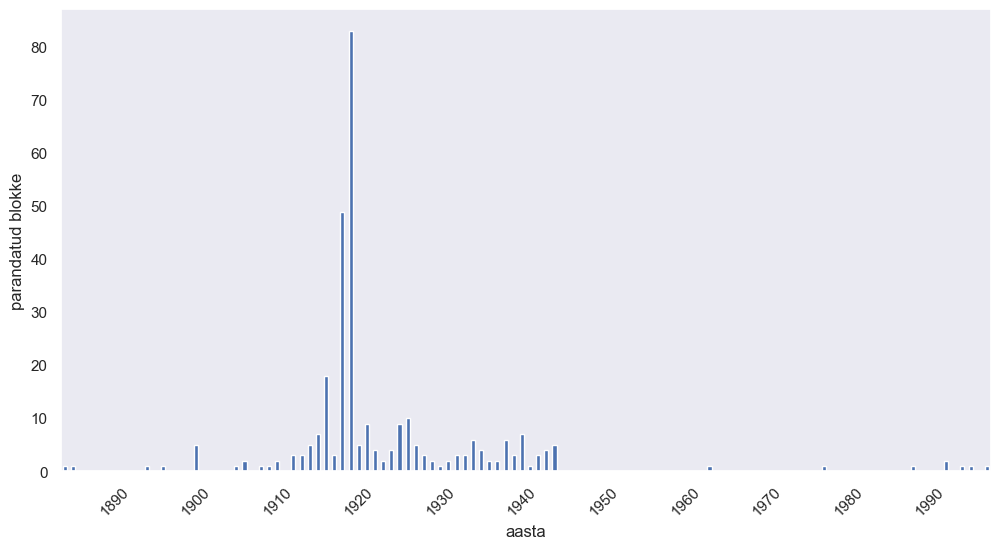

In [1086]:
plt.figure(figsize=(12,6))
reindexed_counts.plot(kind="bar")
ticks_to_show = [year for year in reindexed_counts.index if year % 10 == 0]
plt.xticks(ticks=[reindexed_counts.index.get_loc(year) for year in ticks_to_show], labels=ticks_to_show, rotation=45, ha="center")
plt.grid()
plt.xlabel("aasta")
plt.ylabel("parandatud blokke")
plt.show()

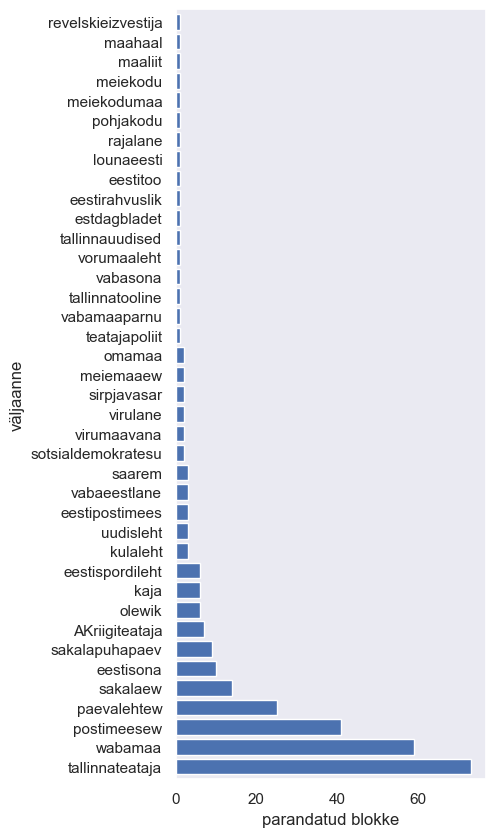

In [1092]:
plt.figure(figsize=(4,10))
title_counts = spans["title"].value_counts()
title_counts.plot(kind="barh", width=0.8)
plt.xlabel("parandatud blokke")
plt.ylabel("väljaanne")
plt.grid()
plt.show()

In [1100]:
titles_over_n1 = title_counts.loc[lambda x: x > 1].index
top_titles = spans.loc[spans["title"].isin(titles_over_n1)].copy()
top_titles["title"] = pd.Categorical(top_titles["title"], categories=titles_over_n1)

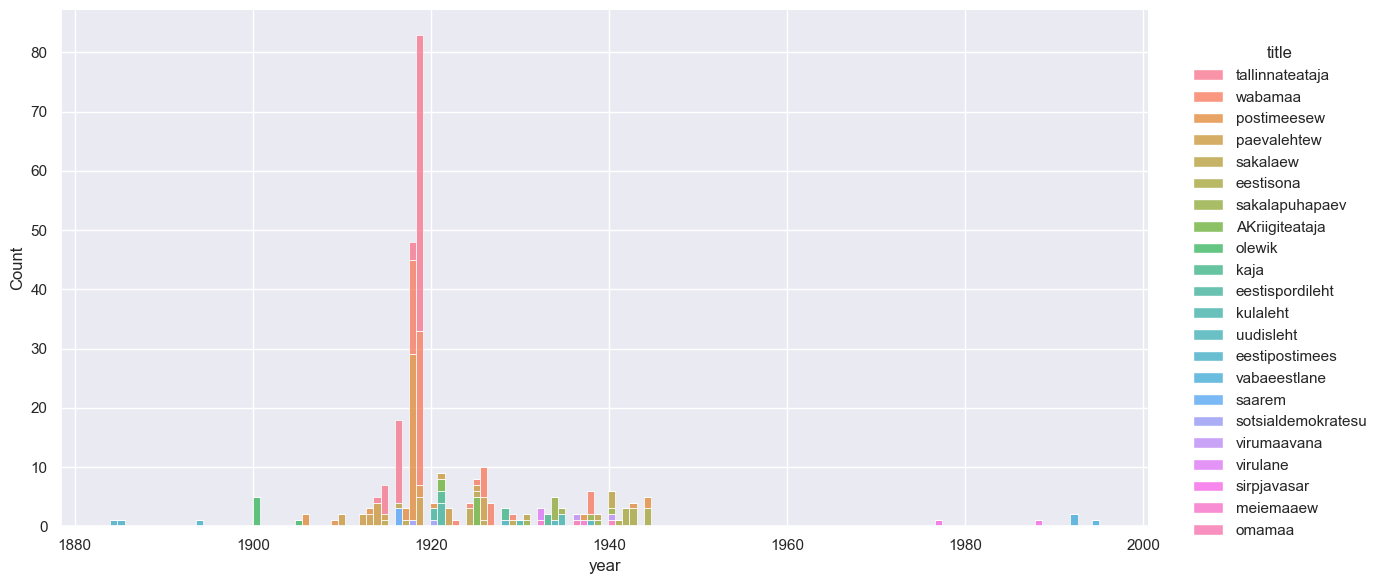

In [1102]:
sns.set_theme()
sns.displot(top_titles, x="year", hue="title", height=6, aspect=2, binwidth=0.8, kind="hist", multiple="stack")
plt.show()

### Fine-tuning preparation

In [18]:
spans = pd.read_csv("data/fine-tuning/training_data_w_meta.tsv", sep="\t", encoding="utf8")

In [19]:
spans

,blockIDunique,pageOID,oldtext,newtext,distance,distance_relative,title,year
0,AKriigiteataja19210308.1.2P2_TB00001,AKriigiteataja19210308.1.2,6. Era-algkoolide juures kerrakhktskse kssliMk...,6. Era-algkoolide juures korraldatakse kooliwa...,320,0.132177,AKriigiteataja,1921
1,AKriigiteataja19211210.1.10P10_TB00001,AKriigiteataja19211210.1.10,"«Vjonikormnisjoni liikmete tasu, kui see termi...","wisjonikommisjoni liikmete tasu, kui see tarwi...",222,0.086180,AKriigiteataja,1921
2,AKriigiteataja19250711.1.19P19_TB00001,AKriigiteataja19250711.1.19,26 cm. pilk. Wooder ainult marul atest rinna j...,"25 cm. pilk. Wooder ainult warukatel, rinna ja...",234,0.095355,AKriigiteataja,1925
3,AKriigiteataja19250714.1.3P3_TB00001,AKriigiteataja19250714.1.3,11. Ohmltse rtö e marus ta mine. 8 2. Reserw- ...,II. Ohwitseride warustamine. § 2. Reserw- ja m...,388,0.164826,AKriigiteataja,1925
4,AKriigiteataja19250714.1.3P3_TB00002,AKriigiteataja19250714.1.3,Märkus!. Wähem lk u i 30 pä ew a kestnud üksik...,Märkus. Wähem kui 30 päewa kestnud üksik õppus...,279,0.131915,AKriigiteataja,1925
...,...,...,...,...,...,...,...,...
295,wabamaa19290214.1.5P5_Page1_Block1,wabamaa19290214.1.5,"keljapäewal, 14. tocebt. 1929. Nk« 39. NelsapZ...","Neljapäewal, 14. veebr. 1929. Nr 38. Neljapäew...",429,0.039064,wabamaa,1929
296,wabamaa19380301.1.2P2_Page1_Block6,wabamaa19380301.1.2,"lega, mis walguStab ja soojendab inimest ta el...","lega, mis walgustab ja soojendab inimest ta el...",449,0.114746,wabamaa,1938
297,wabamaa19380301.1.2P2_Page1_Block24,wabamaa19380301.1.2,Wi^jan^S a..s. v. F. Leihber^ «eskis juhtus õn...,Wiljandis a..s. v. F. Leihber^ weskis juhtus õ...,434,0.143852,wabamaa,1938
298,wabamaa19380301.1.3P3_Page1_Block11,wabamaa19380301.1.3,Kaks töölist kukkus tala»flft alla. vnnetut Ei...,Kaks töölist kukkus talasilt alla. Õnnetus End...,612,0.141209,wabamaa,1938


In [20]:
PROMPT_TEMPLATES = {
    "template-001": "Please assist with reviewing and correcting errors in texts produced by automatic transcription (OCR) of historical documents in Estonian. Your task is to carefully examine the following text and correct any mistakes introduced by the OCR software. The text to correct appears after the segment 'TEXT TO CORRECT:'. Please place the corrected version of the text after the 'CORRECTED TEXT:' segment. Do not write anything else than the corrected text.\n\n TEXT TO CORRECT:\n {ocr_transcription} \n CORRECTED TEXT:"
}

In [21]:
def format_training_data(df, prompt_template):
    formatted_data = []
    for (OCR, GT) in list(zip(spans["oldtext"], spans["newtext"])):
        prompt = prompt_template.format(ocr_transcription=OCR)
        formatted_data.append(
            {"messages": [{"role": "user", "content": prompt}, {"role": "assistant", "content": GT}]}
        )

    return formatted_data

In [22]:
data = format_training_data(spans, PROMPT_TEMPLATES["template-001"])

In [26]:
with open("data/fine-tuning/training_data.jsonl", "w", encoding="utf8") as f:
    for entry in data:
        f.write(json.dumps(entry))
        f.write("\n")

### Pricing

In [27]:
import tiktoken

In [28]:
encoding = tiktoken.encoding_for_model("gpt-3.5-turbo")

In [37]:
total_text = ""
for entry in data:
    for message in entry["messages"]:
        for key, val in message.items():
            if key == "content":
                total_text += val

In [43]:
n_tokens = len(encoding.encode(total_text))
print(n_tokens)

769132


In [47]:
price_per_1m = 8
tokens_m = n_tokens / 1000000
price_per_epoch = tokens_m * price_per_1m
print(price_per_epoch)

6.153056
